In [1]:
import ipyplot

# Exploring scoreboards

## Imports and defaults

In [2]:
import os
import sys
import cv2
import pytesseract
from pycocotools.coco import COCO
import numpy as np

frames_dir = os.path.join("data","frames")
frame_ids = [0,500,600*25]

## Image processing functions & Tesseract config

In [3]:
tesseract_config = "--oem 3 --psm 6 -c tessedit_char_whitelist=>abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

```Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
                        bypassing hacks that are Tesseract-specific.
 ```
 
(Using the default OEM)

In [4]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def median_blur(image):
    return cv2.medianBlur(image,5)
 
def otsu(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

def dilate(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
def erode(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

def opening(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def canny(image):
    return cv2.Canny(image, 100, 200)

## Load sample scoreboards and anno

In [5]:
anno_coco = COCO("data/top-100-shots-rallies-2018-atp-season-scoreboard-annotations_coco_train.json")
anno_coco.info()
imgs = [cv2.imread(os.path.join(frames_dir,f"{i}.jpg"))[:,:,::-1] for i in frame_ids]

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
description: Sportsradar interview task train



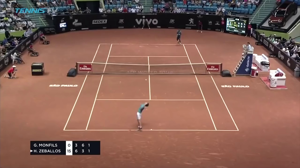
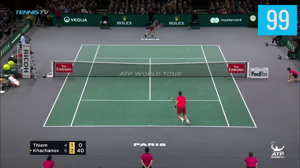
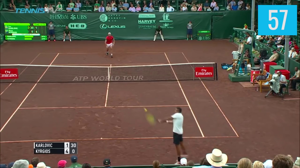


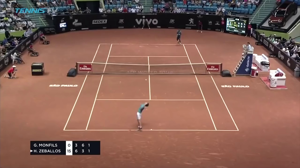
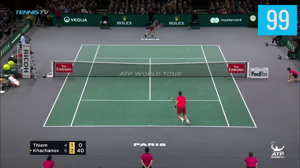
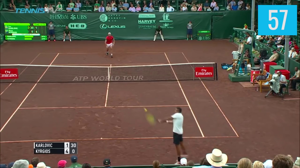

In [6]:
ipyplot.plot_images(imgs, max_images=3, img_width=300)

In [7]:
annos = anno_coco.loadAnns(anno_coco.getAnnIds(frame_ids))
annos

[{'image_id': 0,
  'bbox': [194.95, 905.89, 446.32, 91.23000000000002],
  'category_id': 1,
  'id': 0,
  'iscrowd': 0,
  'area': 40717.77360000001},
 {'image_id': 500,
  'bbox': [193.06, 905.52, 356.22999999999996, 90.47000000000003],
  'category_id': 1,
  'id': 500,
  'iscrowd': 0,
  'area': 32228.128100000005},
 {'image_id': 15000,
  'bbox': [215.65, 913.03, 280.92999999999995, 78.97000000000003],
  'category_id': 1,
  'id': 15000,
  'iscrowd': 0,
  'area': 22185.042100000002}]

In [8]:
scoreboards = []
for img, anno in zip(imgs, annos):
    x, y, w, h = [int(v) for v in anno["bbox"]]
    scoreboards.append(img[y:y+h,x:x+w])

/home/phd/09/igor/miniconda3/envs/mmdet/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)



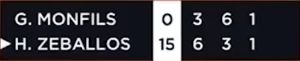
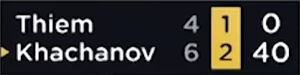
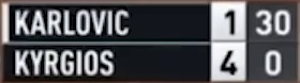


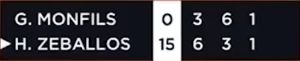
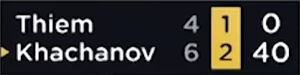
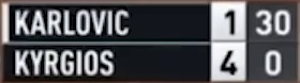

In [9]:
ipyplot.plot_images(scoreboards, max_images=3, img_width=300)

In [10]:
for idx in range(len(scoreboards)):
    print(f"Scoreboard {idx}")
    print(pytesseract.image_to_string(scoreboards[idx], config=tesseract_config))

Scoreboard 0
G MONFlLS O 3 6 1
>H ZEBALLOS 15 6 3 1


Scoreboard 1
Thiem 4 1 O
>Khachanov 6 2 40


Scoreboard 2
IKARLOVEV I30
KYRGIOS 4 o




## Preprocessing scoreboards for Tesseract

In [11]:
for idx in range(len(scoreboards)):
    scoreboard = scoreboards[idx]
    scoreboard = get_grayscale(scoreboard)
    scoreboard = otsu(scoreboard)
    scoreboards[idx] = scoreboard

/home/phd/09/igor/miniconda3/envs/mmdet/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)



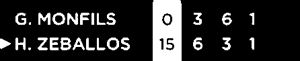
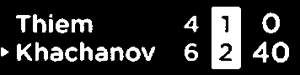
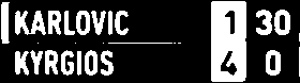


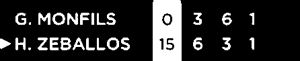
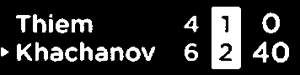
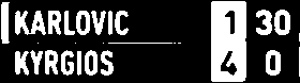

In [12]:
ipyplot.plot_images(scoreboards, max_images=3, img_width=300)

In [13]:
for idx in range(len(scoreboards)):
    print(f"Scoreboard {idx}")
    print(pytesseract.image_to_string(scoreboards[idx], config=tesseract_config))

Scoreboard 0
G MONFlLS O 3 6 1
>H ZEBALLOS 15 6 3 1


Scoreboard 1
Thiem 4 1 O
>Khachanov 6 2 40


Scoreboard 2
IKARLOVLV I30 
KYRGIOS 4 o  




## Parse

In [64]:
import re


class StringProcessor():
    def __init__(self):
        self.alphabetic_replacements = [
            ("1", "l"),
            ("0", "o"),
            ("8", "b"),
        ]
        self.numerical_replacements = [
            ("o", "0"),
            ("O", "0"),
            ("l", "1"),
            ("B", "8")
        ]
    
    def preprocess_alphabetic(self, alpha_string):
        res = alpha_string
        for (c_0, c_r) in self.alphabetic_replacements:
            res = res.replace(c_0, c_r)
        return ''.join([i for i in res if i.isalpha()])
        
    def preprocess_numerical(self, num_string):
        res = num_string
        for (c_0, c_r) in self.numerical_replacements:
            res = res.replace(c_0, c_r)
        return ''.join([i for i in res if i.isdigit()])
        
    def read_values(self, scoreboard_string):
        return [self._read_values(s) for s in scoreboard_string.splitlines()[:2]]
    
    def _read_values(self, noisy_string):
        noisy_string = noisy_string
        player_name = []
        player_surname = []
        score = []
        s_split = re.split('\s|\.', noisy_string)
        # add name, surname, score
        surname_info = max(enumerate(s_split), key=lambda x: len(x[1]))
        surname_id = surname_info[0]
        player_surname.append(surname_info[1])
        for i, s in enumerate(s_split):
            if i < surname_id and s != '>':
                player_name.append(s)  # allow for several initials
            if i > surname_id:
                score.append(s)
        #clean up
        cleaned_name = [self.preprocess_alphabetic(
            x) for x in player_name if x != ""]
        cleaned_surname = [self.preprocess_alphabetic(
            x) for x in player_surname if x != ""]
        cleaned_score = [self.preprocess_numerical(x) for x in score if x != ""] 
        if '>' in s_split[0]:
            serving = True
        else:
            serving = False
        if cleaned_name:
            cleaned_name[0]+=". "
            initial = cleaned_name[0]
        else:
            initial = ""
        cleaned_score = "-".join(cleaned_score)
        return initial+cleaned_surname[0], cleaned_score, serving

In [65]:
string_processor = StringProcessor()
for idx in range(len(scoreboards)):
    noisy_string = pytesseract.image_to_string(scoreboards[idx], config=tesseract_config).upper()
    extracted_info = string_processor.read_values(noisy_string)
    break

In [66]:
noisy_string.splitlines()
extracted_info

[('G. MONFLLS', ['0', '3', '6', '1'], False),
 ('H. ZEBALLOS', ['15', '6', '3', '1'], True)]